# Training SAR using CNN model


In [2]:
# import libraries
import json
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np 
import pandas as pd
import seaborn as sns
import os
import gc
import rasterio as rio
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import  cm
import cv2
from matplotlib import animation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# SAR

SAR is the remote sensing system that is not dependent on the sun’s electromagnetic energy or the thermal properties of the earth. Compared to optical data, microwave (SAR) satellites data is the preferred tool for flood mapping from space due to their capability of capturing the images day/night, irrespective of the weather conditions. The SAR systems operate in the micro-wave band, which are long waves and have the capability to penetrate through clouds, to some degree of vegetation, rain showers, fog and snow. Also, SAR’s frequent revisits make it ideal for flood monitoring.

Active sensors transmit a signal and receive the backscatter characteristics of different surface features (Martinis and Rieke, 2015). The strength of the radar backscatter depends on multiple factors, notably surface roughness, dielectric properties, and local topography in relation to the radar look angle.

The smooth open water surface acts as a specular reflector of the radar pulse, which scatters the radar energy away from the sensor, resulting in minimal signal returned to the satellite. As a result, the stagnant water pixels appear dark in radar data which is in contrast with non-water areas. This makes water pixel differentiation and detection easy in the radar data.

Due to its good capability to distinguish water with other land surfaces, SAR data is more suitable for flood detection. Sentinel-1 twin satellites are one of the best examples for SAR systems.

In [3]:
# import the csv files

s1_data = pd.read_csv('s1_data.csv')
s2_data=pd.read_csv('s2_data.csv')

In [4]:

class CFG:
    """
    This class provides a set of parameters and constants that may be used throughout a machine learning 
    pipeline for image classification, specifically in the context of identifying flooded areas.
    """
    seed = 3 # random initialization of weights in a machine learning model
    img_size = (256,256) # representing the dimensions of an image, specifically 256 x 256 pixels.
    BATCH_SIZE = 3 #  representing the number of samples that will be fed to a machine learning model during training.
    Autotune = tf.data.AUTOTUNE # a constant value from the tf.data.AUTOTUNE module that enables dynamic 
    # allocation of computational resources to improve performance.
    validation_size = 0.2 # a float value of 0.2 representing the fraction of the training dataset to be used for validation during training.
    class_dict= {0:'No Flooding', 
                 1: 'Flooding'}
    
    test_run = False # in training mode

In [5]:
# quick visual confirmation that all label files have corresponding source files in the dataset

# Set the path for Dataset
s1_labels = 'sen12flood/sen12floods_s1_labels/sen12floods_s1_labels/'
s1_tiles = 'sen12flood/sen12floods_s1_source/sen12floods_s1_source/'

s2_tiles = 'sen12flood/sen12floods_s2_source/sen12floods_s2_source/'
s2_labels = 'sen12flood/sen12floods_s2_labels/sen12floods_s2_labels/'


s1_check = 0
for file in os.listdir(s1_labels):
    if os.path.exists(s1_tiles + '/' + file.replace('labels','source')):
        s1_check += 1
        
         
assert s1_check == len(os.listdir(s1_tiles)), 'Not present'
    
s2_check = 0
for file in os.listdir(s2_labels):
    if os.path.exists(s2_tiles + '/' + file.replace('labels','source')):
        s2_check += 1
        
        
assert s2_check == len(os.listdir(s2_tiles)), 'Not present'


s1_check,s2_check 

(3332, 2237)

# Interpreting Radar Images
Source: Alaska Satellite Facility (ASF)

The interpretation of synthetic aperture radar (SAR) images is not straightforward. The reasons include the non-intuitive, side-looking geometry. Here are some general rules of thumb:

Regions of calm water and other smooth surfaces appear black, because the radar pulse reflects away from the spacecraft.

Rough surfaces appear brighter, as they reflect the radar in all directions, and more of the energy is scattered back to the antenna. Rough surface backscatter even more brightly when it is wet.

Any slopes lead to geometric distortions. Steeper angles lead to more extreme layover, in which the signals from the tops of mountains or other tall objects “lay over” on top of other signals, effectively creating foreshortening. Mountaintops always appear to tip towards the sensor.

Layover is highlighted by bright pixel values. The various combinations of the polarization for the transmitted and received signals have a large impact on the backscattering of the signal. The right choice of polarization can help emphasize particular topographic features.

In urban areas, it is at times challenging to determine the orbit direction. All buildings that are perfectly perpendicularly aligned to the flight direction show very bright returns.

Surface variations near the size of the radar's wavelength cause strong backscattering. If the wavelength is a few centimeters long, dirt clods and leaves might backscatter brightly.

A longer wavelength would be more likely to scatter off boulders than dirt clods, or tree trunks rather than leaves.

Wind-roughened water can backscatter brightly when the resulting waves are close in size to the incident radar's wavelength.

Hills and other large-scale surface variations tend to appear bright on one side and dim on the other. (The side that appears bright was facing the SAR.)

Due to the reflectivity and angular structure of buildings, bridges and other human-made objects, these targets tend to behave as corner reflectors which are used for calibrating NISAR instruments (see photo) and show up as bright spots in a SAR image. A particularly strong response — for example, from a corner reflector or ASF's receiving antenna — can look like a bright cross in a processed SAR image.

# Loading multiple raster bands as single raster

The use of raster images is particularly important in CNNs because these networks are designed to work with multi-dimensional input data, such as images and videos, which can be represented as 2D or 3D arrays of pixels. Each pixel in the array corresponds to a specific location in the image, and its value represents the intensity of the color or brightness at that location.

The use of raster images in CNNs allows the network to learn features from the raw pixel data, rather than relying on pre-processed features that may not be relevant to the specific problem being solved. Additionally, CNNs can handle the large amounts of data that are typically present in raster images, as each pixel contains its own value and multiple channels can be used to represent different aspects of the image (e.g. red, green, and blue channels in RGB images).

In [6]:
def load_raster(filepath): # filepath of the raster file to be loaded
    '''load a single band raster'''
    with rio.open(filepath) as file: 
        # the squeeze method is called on the resulting array to remove any singleton dimensions 
        # (i.e., dimensions with size 1). This is done using the axis=0 argument, 
        # which tells squeeze to remove any singleton dimensions along the first axis.  
        raster = file.read().squeeze(axis=0)

        
    #we aregetting back the 2D image from singleton(1D)
    return raster

In [ ]:
def load_s1_tiffs(folder,
                  scaling_values=[50.,100.]):
    images = []
    i = 0
    for im in sorted(os.listdir(folder)):
         
        if im.rsplit('.',maxsplit=1)[1] == 'tif':
            
            path = folder + '/' + im
            band = load_raster(path)
            band = band / scaling_values[i]
            
            band = cv2.resize(band,
                              CFG.img_size)
            
            images.append(band)
            i+=1 
                    
    return np.dstack(images)


def load_s2_tiffs(folder,
                  scaling_value=10000.):
    images = []
    for im in sorted(os.listdir(folder)):
        if im.rsplit('.',maxsplit=1)[1] == 'tif':    
            path = folder + '/' + im
            band = load_raster(path)
            band = band/ scaling_value
            
            band = cv2.resize(band,CFG.img_size)
            images.append(band)   

    return np.dstack(images)
                    
def load_rgb_tiffs(folder,
                  scaling_value=10000.):
    '''load R,G and B bands'''
    
    images = []
    for im in sorted(os.listdir(folder)):
        name,file_format = im.rsplit('.',maxsplit=1)
        if ((file_format== 'tif') and (name in ['B02','B03','B04'])):    
            path = folder + '/' + im
            band = load_raster(path)
            band = band/ scaling_value
            
            band = cv2.resize(band,CFG.img_size)
            images.append(band)   

    return np.dstack(images)[:,:,::-1]


    
def tf_load_s1(path):    
    path = path.numpy().decode('utf-8')
    return load_s1_tiffs(path)
    
    

def tf_load_s2(path):    
    path = path.numpy().decode('utf-8')
    return load_s2_tiffs(path)


def tf_load_rgb(path):    
    path = path.numpy().decode('utf-8')
    return load_rgb_tiffs(path)
    
def process_image_s1(filename):
    '''function for preprocessing in tensorflow data'''
    
    return tf.py_function(tf_load_s1, 
                          [filename], 
                          tf.float32)



def process_image_s2(filename):
    '''function for preprocessing in tensorflow data'''
    
    return tf.py_function(tf_load_s2, 
                          [filename], 
                          tf.float32)



def process_image_rgb(filename):
    '''function for preprocessing in tensorflow data'''
    
    return tf.py_function(tf_load_rgb, 
                          [filename], 
                          tf.float32)

In [ ]:
def count_rasters_in_folder(path):
    count = 0 
    
    for file in os.listdir(path):
        if file.rsplit('.',1)[1] == 'tif':
            count +=1 
            
    return count 
    
    
s2_data['raster_count'] = s2_data.image_dir.apply(lambda x : count_rasters_in_folder(x))

#value counts 
s2_data['raster_count'].value_counts()


s2_data=s2_data[s2_data['raster_count']==12] # take only valid rasters
# s2_data[s2_data['raster_count']==0]['location_id'].value_counts()

# Visualize some images

lets take a look at some optical RGB images

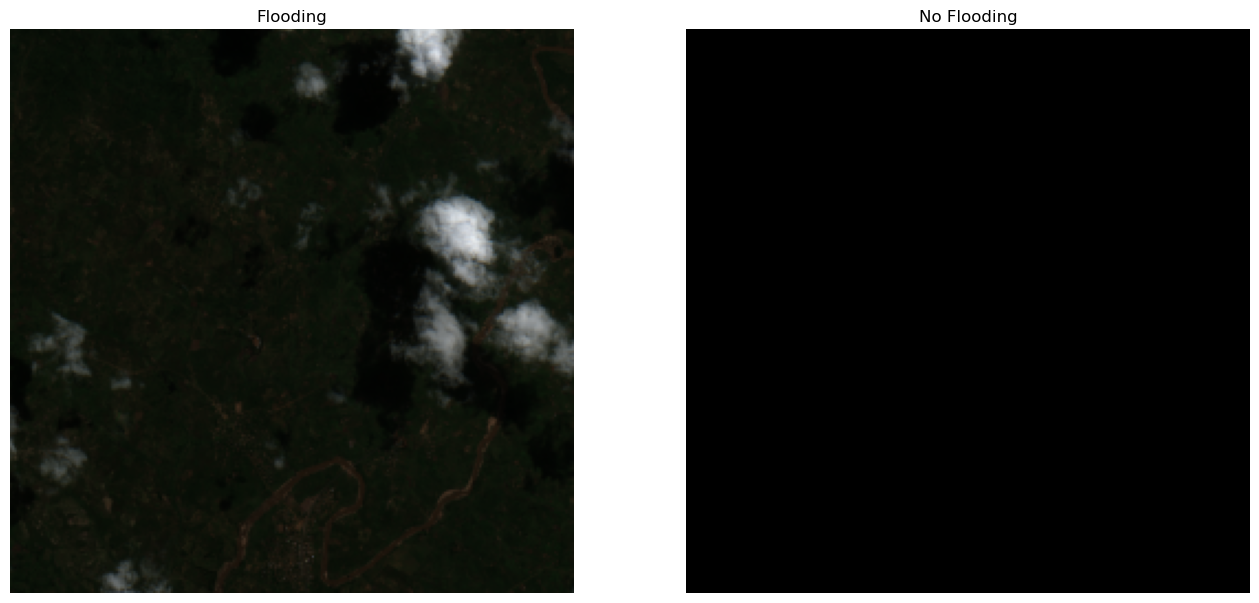

In [9]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

plt.subplot(1,2,1)
chk = load_s2_tiffs(s2_data.query('label==1')['image_dir'].values[11])
plt.imshow(chk[:,:,1:4][:,:,::-1])
plt.title('Flooding')
plt.axis('off')


chk = load_s2_tiffs(s2_data.query('label==0')['image_dir'].values[20])
plt.subplot(1,2,2)
plt.imshow(chk[:,:,1:4][:,:,::-1])
plt.title('No Flooding')
plt.axis('off')
plt.show()


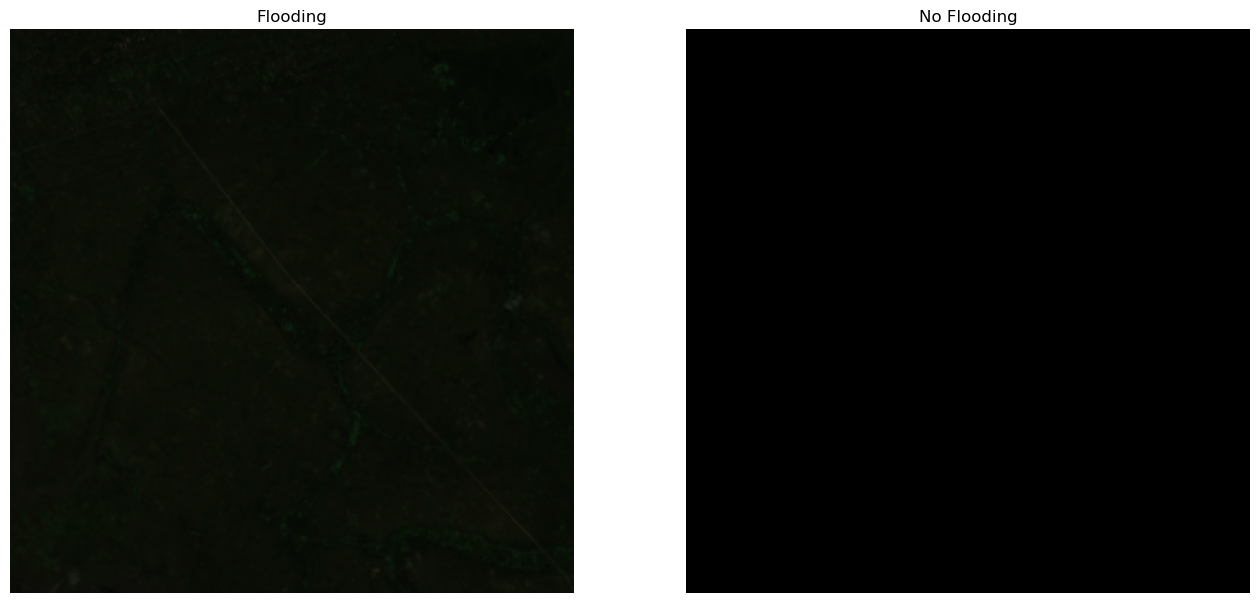

In [10]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

plt.subplot(1,2,1)
chk = load_s2_tiffs(s2_data.query('label==1')['image_dir'].values[101])
plt.imshow(chk[:,:,1:4][:,:,::-1])
plt.title('Flooding')
plt.axis('off')


chk = load_s2_tiffs(s2_data.query('label==0')['image_dir'].values[11])
plt.subplot(1,2,2)
plt.imshow(chk[:,:,1:4][:,:,::-1])
plt.title('No Flooding')
plt.axis('off')
plt.show()

Some SAR images

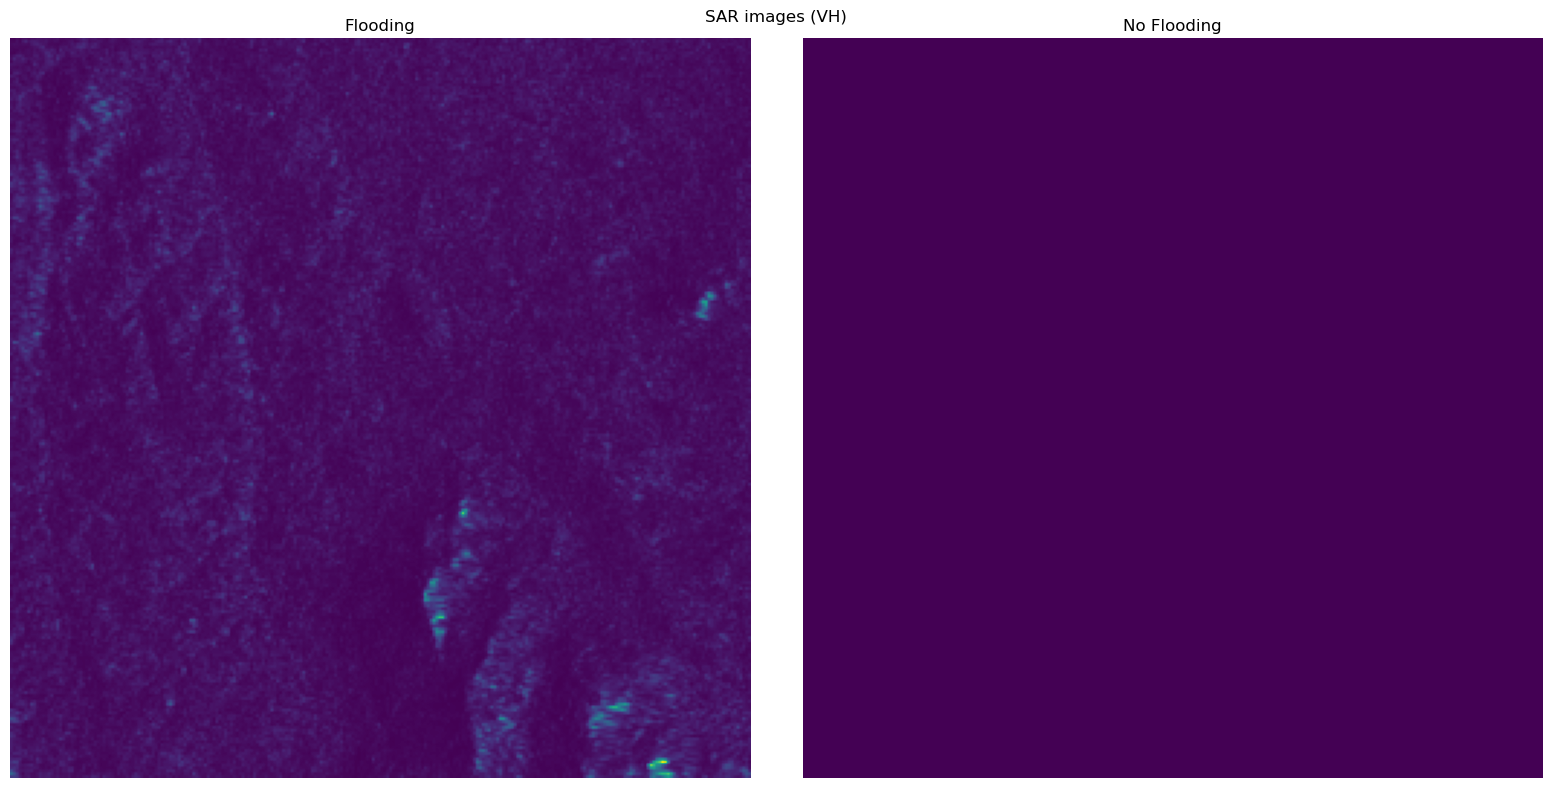

In [11]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

plt.suptitle('SAR images (VH)')

plt.subplot(1,2,1)


chk = load_s1_tiffs(s1_data.query('label==1')['image_dir'].values[11])
plt.imshow(chk[:,:,1])
plt.title('Flooding')
plt.axis('off')


chk = load_s2_tiffs(s2_data.query('label==0')['image_dir'].values[11])
plt.subplot(1,2,2)
plt.imshow(chk[:,:,1])
plt.title('No Flooding')
plt.axis('off')

plt.tight_layout()
plt.show()

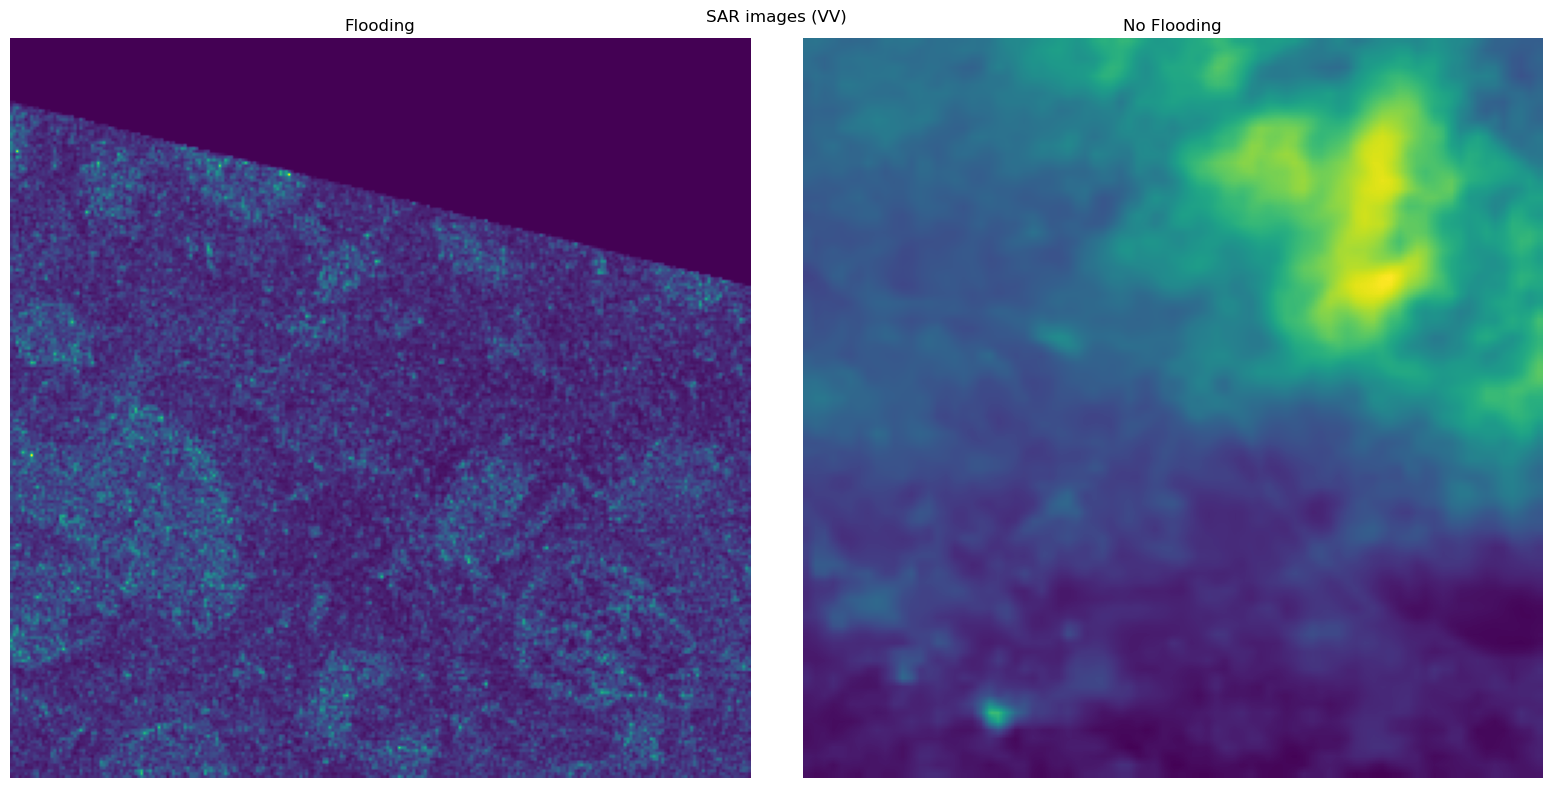

In [12]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
plt.suptitle('SAR images (VV)')


r_idx = np.random.randint(low=0,high=500)
plt.subplot(1,2,1)
chk = load_s1_tiffs(s1_data.query('label==1')['image_dir'].values[r_idx])
plt.imshow(chk[:,:,0])
plt.title('Flooding')
plt.axis('off')


chk = load_s2_tiffs(s2_data.query('label==0')['image_dir'].values[r_idx])
plt.subplot(1,2,2)
plt.imshow(chk[:,:,0])
plt.title('No Flooding')
plt.axis('off')
plt.tight_layout()

plt.show()

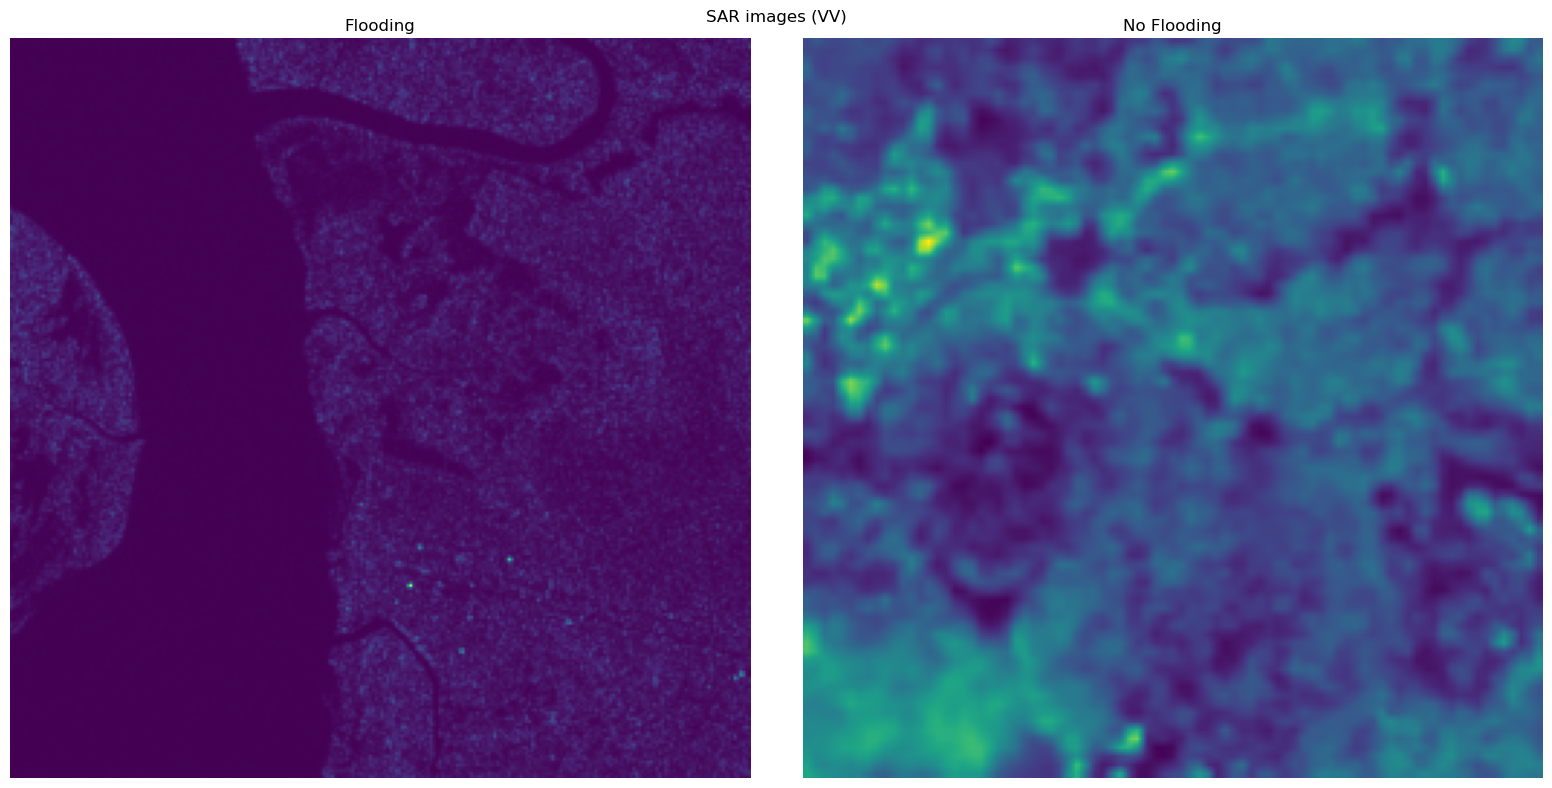

In [13]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
plt.suptitle('SAR images (VV)')


r_idx = np.random.randint(low=0,high=500)
plt.subplot(1,2,1)
chk = load_s1_tiffs(s1_data.query('label==1')['image_dir'].values[r_idx])
plt.imshow(chk[:,:,0])
plt.title('Flooding')
plt.axis('off')


chk = load_s2_tiffs(s2_data.query('label==0')['image_dir'].values[r_idx])
plt.subplot(1,2,2)
plt.imshow(chk[:,:,0])
plt.title('No Flooding')
plt.axis('off')
plt.tight_layout()

plt.show()


Lets look at the distribution of target values

In [14]:
s1_data.label.value_counts()

0    2300
1    1031
Name: label, dtype: int64

In [15]:
s2_data.label.value_counts()

0    1633
1     505
Name: label, dtype: int64

In [16]:
# fig,ax = plt.subplots(1,2,figsize=(16,8))

# plt.subplot(1,2,1)
# sns.countplot(s1_data.label)
# plt.title('Sentinel -1 target distribution')


# plt.subplot(1,2,2)
# sns.countplot(s2_data.label)
# plt.title('Sentinel - 2 target distribution')
# plt.show()

In [17]:
#isolating single loaction ids (as they will be a problem for stratification)

# single example locations 
single_index = s2_data['location_id'].value_counts()[s2_data['location_id'].value_counts()==1].index

single_index_df = s2_data[s2_data['location_id'].isin(single_index)].reset_index(drop=True)
s2_data0 = s2_data[~(s2_data['location_id'].isin(single_index))].reset_index(drop=True)

s2_data0.shape,single_index_df.shape

((2132, 8), (6, 8))

In [18]:
#traintest split 

s1_data_tr,s1_data_val= train_test_split(s1_data,
                                          test_size = CFG.validation_size,
                                          random_state = CFG.seed,
                                          stratify = s1_data.location_id)



s2_data_tr,s2_data_val = train_test_split(s2_data0,
                                          test_size = CFG.validation_size,
                                          random_state = CFG.seed,
                                          stratify =  s2_data0.location_id)

s2_data_tr = s2_data_tr.append(single_index_df,ignore_index=True)

del s2_data0;gc.collect()

C:\Users\adrij\AppData\Local\Temp\ipykernel_1660\104170447.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s2_data_tr = s2_data_tr.append(single_index_df,ignore_index=True)


15738

In [19]:
s1_data_tr.label.value_counts(1),s1_data_val.label.value_counts(1)

(0    0.690691
 1    0.309309
 Name: label, dtype: float64,
 0    0.689655
 1    0.310345
 Name: label, dtype: float64)

In [20]:
s2_data_tr.label.value_counts(1),s2_data_val.label.value_counts(1)

(0    0.768556
 1    0.231444
 Name: label, dtype: float64,
 0    0.744731
 1    0.255269
 Name: label, dtype: float64)

In [21]:
def augment_image_multispectral(image):
    '''perform simple image augmentations'''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, size=(*CFG.img_size,12))
    
    rot = tf.random.normal((1,),mean = 0.35, stddev=0.15)
    
    if rot > 0.5:
        image = tf.image.rot90(image)

    return image 

def augment_image(image):
    '''perform simple image augmentations'''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, size=(*CFG.img_size,3))
    
    rot = tf.random.normal((1,),mean = 0.35, stddev=0.15)
    
    if rot > 0.5:
        image = tf.image.rot90(image)

    return image 

In [22]:
def get_tf_dataset(image_paths,
                   labels=None, # put none for test data set
                   image_processing_fn=None,
                   augment_fn = None
                  ):
    
    '''returns a tf dataset object
    Inputs: 
    image_paths : paths to images
    labels: labels of each image
    image_processing_fn:  function to load and preprocess images 
    augment_fn : function to augment images '''
    
    #seperate datasets
    if labels is not None:
        labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
    
    
    
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    #load images 
    image_dataset = image_dataset.map(image_processing_fn,
                                      num_parallel_calls=tf.data.AUTOTUNE)
     
    if augment_fn is not None:
        
        image_dataset = image_dataset.map(augment_fn,
                                          num_parallel_calls=tf.data.AUTOTUNE)
     
    
    if labels is not None:
        return tf.data.Dataset.zip((image_dataset,labels_dataset))
    
    
    return image_dataset



def optimize_pipeline(tf_dataset,
                      batch_size = CFG.BATCH_SIZE,
                      Autotune_fn = CFG.Autotune,
                      cache= False,
                      batch = True):
    
    
    
    # prefetch(load the data with cpu,while gpu is training) the data in memory 
    tf_dataset = tf_dataset.prefetch(buffer_size=Autotune_fn)  
    if cache:
        tf_dataset = tf_dataset.cache()                        # store data in RAM  
        
    tf_dataset =  tf_dataset.shuffle(buffer_size=50)         # shuffle 
    
    if batch:
        tf_dataset = tf_dataset.batch(batch_size)              #split the data in batches  
    
    return tf_dataset

In [23]:
# Sentinel 1 dataset (not using augmentation here)

S1_dataset_tr = optimize_pipeline(tf_dataset=get_tf_dataset(image_paths = s1_data_tr.image_dir.values,
                                               labels = s1_data_tr.label,
                                               image_processing_fn = process_image_s1),
                                  
                                  batch_size = 3 * CFG.BATCH_SIZE)


S1_dataset_val = optimize_pipeline(tf_dataset = get_tf_dataset(image_paths = s1_data_val.image_dir.values,
                                                           labels = s1_data_val.label,
                                                           image_processing_fn = process_image_s1 ),
                                   batch_size = 3* CFG.BATCH_SIZE
                                  )

In [24]:
#sentinel 2 dataset 
S2_dataset_tr = optimize_pipeline(get_tf_dataset(image_paths = s2_data_tr.image_dir.values,
                                                   labels = s2_data_tr.label,
                                                   image_processing_fn = process_image_s2,
                                                   augment_fn = augment_image_multispectral)
                                 )


S2_dataset_val = optimize_pipeline(get_tf_dataset(image_paths = s2_data_val.image_dir.values,
                                                   labels = s2_data_val.label,
                                                   image_processing_fn = process_image_s2,
                                                   augment_fn = augment_image_multispectral)
                                  )

In [25]:
RGB_dataset_tr = optimize_pipeline(get_tf_dataset(image_paths = s2_data_tr.image_dir.values,
                                                   labels = s2_data_tr.label,
                                                   image_processing_fn = process_image_rgb,
                                                   augment_fn = augment_image),
                                   batch_size = 3* CFG.BATCH_SIZE
                                 )


RGB_dataset_val = optimize_pipeline(get_tf_dataset(image_paths = s2_data_val.image_dir.values,
                                                   labels = s2_data_val.label,
                                                   image_processing_fn = process_image_rgb,
                                                   augment_fn = augment_image),
                                    batch_size = 3* CFG.BATCH_SIZE
                                  )

In [26]:
# max_vals_vv = []
# mean_vals_vv =[]


# max_vals_vh = []
# mean_vals_vh =[]

# for x,y in S1_dataset_tr.as_numpy_iterator():
#     # vv band 
#     max_vals_vv.append(x[:,:,:,0].max()); mean_vals_vv.append(x[:,:,:,0].mean())
    
#     # vh band 
#     max_vals_vh.append(x[:,:,:,1].max()); mean_vals_vh.append(x[:,:,:,1].mean())
    
# # band 1value distributions 
# plt.figure(figsize=(16,10))

# sns.distplot(max_vals_vv,label = 'VV band Max values',color='b')
# # sns.distplot(mean_vals_vv,label = 'VV band Mean values',color = 'g')

# plt.legend()

# plt.title('VV band values Distribution')
# plt.show()

# # band 1value distributions 
# plt.figure(figsize=(16,10))

# sns.distplot(max_vals_vh,label = 'VH band Max values',color='b')
# # sns.distplot(mean_vals_vh,label = 'VH band Mean values',color = 'g')


# plt.title('VH band values Distribution')

# plt.legend()
# plt.show()

In [27]:
for x,y in S1_dataset_tr.take(1): # take one batch for checking 
    print(f'shape of SAR dataset input {x.shape}')

shape of SAR dataset input (9, 256, 256, 2)


In [28]:
for x,y in S2_dataset_tr.take(1): # take one batch for checking 
    print(f'shape of MultiSpectral dataset input {x.shape}')

shape of MultiSpectral dataset input (3, 256, 256, 12)


In [29]:
for x,y in RGB_dataset_tr.take(1): # take one batch for checking 
    print(f'shape of MultiSpectral dataset input {x.shape}')

shape of MultiSpectral dataset input (9, 256, 256, 3)


In [30]:
def multichannel_cnn(num_channels:int,
                     hidden_units:int, #number of  hidden dense 
                     weights = None  # none for random init, use imagenet for imagenet weights 
                    ):
    '''model that takes multiple channel as input, instead of using the rgb channels as by default'''
    
    
    backbone = tf.keras.applications.resnet_v2.ResNet50V2(
                                            include_top=False,
                                            input_shape = (*CFG.img_size,num_channels),
                                            weights=weights,
                                            pooling = 'avg')
    
    
    x = tf.keras.layers.BatchNormalization()(backbone.output)
    x = tf.keras.layers.Dense(hidden_units,
                              activation = 'relu')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate = 0.2)(x)

    
    
    
    final_out = tf.keras.layers.Dense(2,
                                      activation = 'softmax')(x)
    
    
    #make a model 
    model = tf.keras.Model(inputs = backbone.input, 
                  outputs = final_out)
    
    return model 


# plot train and val acc as  a function of epochs
def plot_history(history,addn_metric=None):
    '''
    Inputs
    history:history object from tensorflow
    add_metric: metric name in the history (like f1_score)'''
    his=pd.DataFrame(history.history)
    
    if addn_metric:
        plt.subplots(1,3,figsize=(20,6))
        
        #loss:
        ax1=plt.subplot(1,3,1)
        ax1.plot(range(len(his)),his['loss'],color='g',label='training')
        ax1.plot(range(len(his)),his['val_loss'],color='r',label='validation')
        ax1.set_xlabel('EPOCHS')
        ax1.set_ylabel('LOSS')
        ax1.legend()
        ax1.set_title('Loss Per Epoch')

        #accuracy
        ax2=plt.subplot(1,3,2)
        ax2.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
        ax2.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')
        ax2.set_xlabel('EPOCHS')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title('Accuracy Per Epoch')

    
        
        ax3= plt.subplot(1,3,3)
        ax3.plot(range(len(his)),his[f'{addn_metric}'],color='g',label='training')
        ax3.plot(range(len(his)),his[f'val_{addn_metric}'],color='r',label='validation')
        ax3.set_xlabel('EPOCHS')
        ax3.set_ylabel(f'{addn_metric}')
        ax3.legend()
        ax3.set_title(f'{addn_metric} Per Epoch')

        
    else:
        plt.subplots(1,2,figsize=(20,8))
        
    
    
        #loss:
        ax1=plt.subplot(1,2,1)
        ax1.plot(range(len(his)),his['loss'],color='g',label='training')
        ax1.plot(range(len(his)),his['val_loss'],color='r',label='validation')
        ax1.set_xlabel('EPOCHS')
        ax1.set_ylabel('LOSS')
        ax1.legend()
        ax1.set_title('Loss Per Epoch')

        #accuracy
        ax2=plt.subplot(1,2,2)
        ax2.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
        ax2.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')
        ax2.set_xlabel('EPOCHS')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title('Accuracy Per Epoch')

        
    
    
    plt.show()

In [31]:
#from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [32]:
SAR_CNN = multichannel_cnn(num_channels = 2,
                           hidden_units = 512, #number of  hidden dense 
                          )



SAR_CNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy',f1_score,recall_m,precision_m]
               )

#check on some data 
# SAR_CNN(x)



c:\Users\adrij\anaconda3\lib\site-packages\keras\applications\resnet.py:159: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [33]:
!mkdir CNN_models

In [37]:
EPOCHS = 2 if CFG.test_run else 25
# callbacks 
#reduce_learning rate
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(patience=3,
                                                factor=0.75,
                                                min_delta=1e-2,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                mode='max')

#early stopping 
early_stopping=tf.keras.callbacks.EarlyStopping(patience=15,
                                              min_delta=1e-3,
                                              monitor='val_accuracy',
                                              restore_best_weights=True,
                                              mode='max')


# exponential decay 

def lr_scheduler(epoch, lr):
    '''learning rate scheduler, decays expo after the tenth epoch'''

    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    

    
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)


callbacks_1= [reduce_lr,early_stopping,learning_scheduler]

Epoch 1/25
296/296 [==============================] - 598s 2s/step - loss: 0.3963 - accuracy: 0.8183 - f1_score: 0.4488 - recall_m: 0.9527 - precision_m: 0.3093 - val_loss: 0.6652 - val_accuracy: 0.7226 - val_f1_score: 0.4583 - val_recall_m: 0.9467 - val_precision_m: 0.3185 - lr: 1.9965e-05
Epoch 2/25
296/296 [==============================] - 588s 2s/step - loss: 0.3689 - accuracy: 0.8262 - f1_score: 0.4548 - recall_m: 0.9797 - precision_m: 0.3093 - val_loss: 0.6666 - val_accuracy: 0.7226 - val_f1_score: 0.4607 - val_recall_m: 0.9867 - val_precision_m: 0.3185 - lr: 1.9965e-05
Epoch 3/25
296/296 [==============================] - 917s 3s/step - loss: 0.3920 - accuracy: 0.8026 - f1_score: 0.4486 - recall_m: 0.9527 - precision_m: 0.3093 - val_loss: 0.5319 - val_accuracy: 0.7301 - val_f1_score: 0.4581 - val_recall_m: 0.9733 - val_precision_m: 0.3185 - lr: 1.9965e-05
Epoch 4/25
296/296 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8149 - f1_score: 0.4500 - recall_

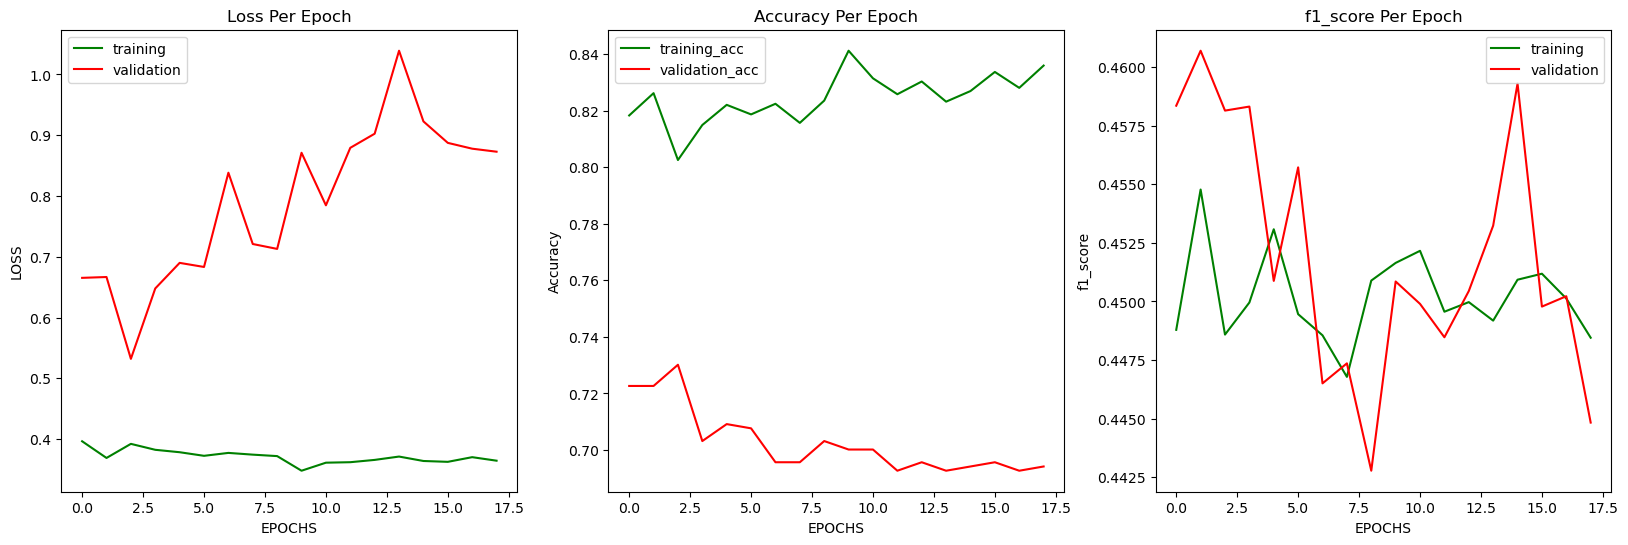

In [38]:
hist1 = SAR_CNN.fit(S1_dataset_tr,
                    validation_data = S1_dataset_val,
                    epochs = EPOCHS,
                    callbacks = callbacks_1
                   )


#save model
sar_model_path = 'CNN_models/SAR_CNN.h5'
SAR_CNN.save(filepath = 'CNN_models/SAR_CNN.h5')


#plot history 
plot_history(hist1,'f1_score')